In [10]:
import torch
from src.model.mae_vit import SSL_MAE, SSL_MAEViT, SSL_MAEPretrainDecoder

model = SSL_MAE(
    backbone=dict(
        type='SSL_MAEViT',
        # Явное задание параметров для ViT-Tiny
        arch=dict(
            embed_dims=192,
            num_layers=12,
            num_heads=3,
            feedforward_channels=192 * 4,  # Обычно 4x от embed_dim
        ),
        img_size=224,
        patch_size=16,
        mask_ratio=0.75,
        init_cfg=[
            dict(type='Xavier', layer='Linear', distribution='uniform'),
            dict(type='Constant', layer='LayerNorm', val=1.0, bias=0.0)
        ],
    ),
    neck=dict(
        type='SSL_MAEPretrainDecoder',
        embed_dim=192,        # Должно совпадать с embed_dims энкодера
        decoder_embed_dim=192,# Уменьшаем размер декодера для tiny модели
        decoder_depth=4,      # Можно уменьшить глубину (стандартно 8)
        decoder_num_heads=6,  # 192 / 32 = 6 голов (или 3)
        mlp_ratio=4,
        init_cfg=[
            dict(type='Xavier', layer='Linear', distribution='uniform'),
            dict(type='Constant', layer='LayerNorm', val=1.0, bias=0.0)
        ],
    ),
    head=dict(
        type='SSL_MAEPretrainHead',
        loss=dict(
            type='PixelReconstructionLoss',
            criterion='L2',
        ),

        # norm_pix=True,  # Рекомендуется для MAE
    ),

)

model.backbone.init_weights()
model.neck.init_weights()
model.head.init_weights()




12/13 23:53:46 - mmengine - INFO - 
cls_token - torch.Size([1, 1, 192]): 
The value is the same before and after calling `init_weights` of SSL_MAEViT  
 
12/13 23:53:46 - mmengine - INFO - 
pos_embed - torch.Size([1, 197, 192]): 
The value is the same before and after calling `init_weights` of SSL_MAEViT  
 
12/13 23:53:46 - mmengine - INFO - 
patch_embed.projection.weight - torch.Size([192, 3, 16, 16]): 
The value is the same before and after calling `init_weights` of SSL_MAEViT  
 
12/13 23:53:46 - mmengine - INFO - 
patch_embed.projection.bias - torch.Size([192]): 
The value is the same before and after calling `init_weights` of SSL_MAEViT  
 
12/13 23:53:46 - mmengine - INFO - 
layers.0.ln1.weight - torch.Size([192]): 
The value is the same before and after calling `init_weights` of SSL_MAEViT  
 
12/13 23:53:46 - mmengine - INFO - 
layers.0.ln1.bias - torch.Size([192]): 
The value is the same before and after calling `init_weights` of SSL_MAEViT  
 
12/13 23:53:46 - mmengine - INF

In [11]:
model.train()

SSL_MAE(
  (data_preprocessor): SelfSupDataPreprocessor()
  (backbone): SSL_MAEViT(
    (patch_embed): PatchEmbed(
      (adaptive_padding): AdaptivePadding()
      (projection): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
    )
    (drop_after_pos): Dropout(p=0, inplace=False)
    (layers): ModuleList(
      (0-11): 12 x TransformerEncoderLayer(
        (ln1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
        (attn): MultiheadAttention(
          (qkv): Linear(in_features=192, out_features=576, bias=True)
          (proj): Linear(in_features=192, out_features=192, bias=True)
          (proj_drop): Dropout(p=0, inplace=False)
          (out_drop): DropPath()
          (gamma1): Identity()
        )
        (ln2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
        (ffn): FFN(
          (layers): Sequential(
            (0): Sequential(
              (0): Linear(in_features=192, out_features=768, bias=True)
              (1): GELU(approximate='none')
    

In [12]:
from PIL import Image
import torchvision.transforms as T

# Загружаем изображение
image_path = 'image.png'
image = Image.open(image_path).convert('RGB')

# Преобразование: изменение размера и конвертация в тензор
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
])

# Применяем трансформации и добавляем batch dimension
imgs = transform(image).unsqueeze(0).repeat(128, 1, 1, 1)

data = dict(inputs=imgs, data_samples=None)

# ВАЖНО: Модель возвращает features при обычном вызове model(inputs).
# Чтобы получить loss, нужно явно вызвать метод loss или передать mode='loss' (если поддерживается).
# Для SSL_MAE правильный способ получить loss вручную - вызвать метод loss.
losses = model.loss(inputs=imgs, data_samples=None)['loss'].mean()


print(f"Initial loss with real image: {losses.item()}")


Initial loss with real image: 0.47120168805122375


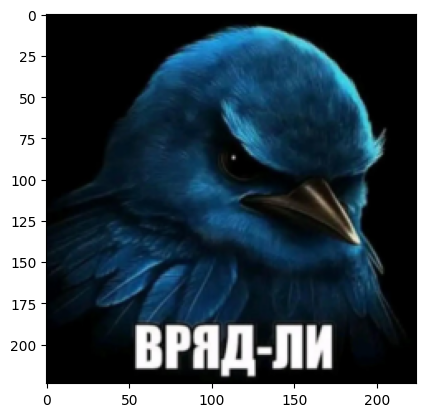

In [13]:
import matplotlib.pyplot as plt
img = imgs[0].permute(1, 2, 0)
plt.imshow(img)
plt.show()


In [14]:
# Дебаг training loop - обучение на одной картинке
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
# Настройки обучения
num_epochs = 3000
warmup_epochs = 200
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Перемещаем модель и данные на устройство
model = model.to(device)
imgs = imgs.to(device)

# Создаем оптимизатор
initial_lr = 1e-4


optimizer = torch.optim.AdamW(model.parameters(), lr=initial_lr, weight_decay=0.05, betas=(0.9, 0.95))

# Cosine decay scheduler с warmup
def get_lr(epoch):
    if epoch < warmup_epochs:
        # Linear warmup
        return initial_lr * (epoch + 1) / warmup_epochs
    else:
        # Cosine decay
        progress = (epoch - warmup_epochs) / (num_epochs - warmup_epochs)
        return initial_lr * 0.5 * (1 + math.cos(math.pi * progress))

# Списки для хранения истории обучения
train_losses = []

# Training loop
model.train()
for epoch in tqdm(range(num_epochs), desc="Training"):
    # Подготовка данных
    lr = get_lr(epoch)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    data = dict(inputs=imgs, mode='loss')

    # Forward pass
    optimizer.zero_grad()
    outputs = model(**data)
    loss = outputs['loss'].mean()

    # Backward pass
    loss.backward()
    optimizer.step()

    # Сохраняем loss
    train_losses.append(loss.item())

    # Логируем каждые 5 эпох
    # if (epoch + 1) % 50 == 0:
    #     print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}")

print(f"\nTraining completed!")
print(f"Initial loss: {train_losses[0]:.6f}")
print(f"Final loss: {train_losses[-1]:.6f}")
print(f"Loss reduction: {((train_losses[0] - train_losses[-1]) / train_losses[0] * 100):.2f}%")

Using device: cuda


Training:   0%|          | 0/3000 [00:00<?, ?it/s]

Training: 100%|██████████| 3000/3000 [02:22<00:00, 21.09it/s]


Training completed!
Initial loss: 0.472684
Final loss: 0.000594
Loss reduction: 99.87%


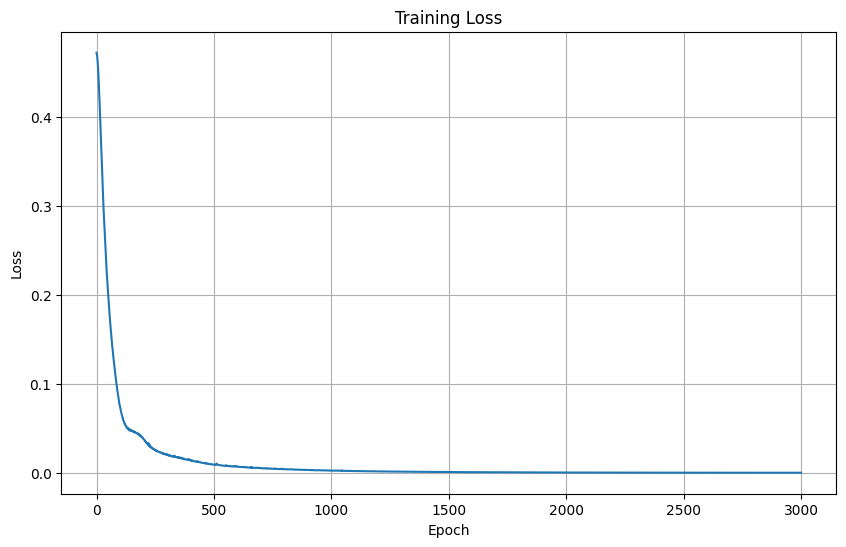

In [15]:
# Визуализация кривой обучения
plt.figure(figsize=(10, 6))
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)
plt.show()


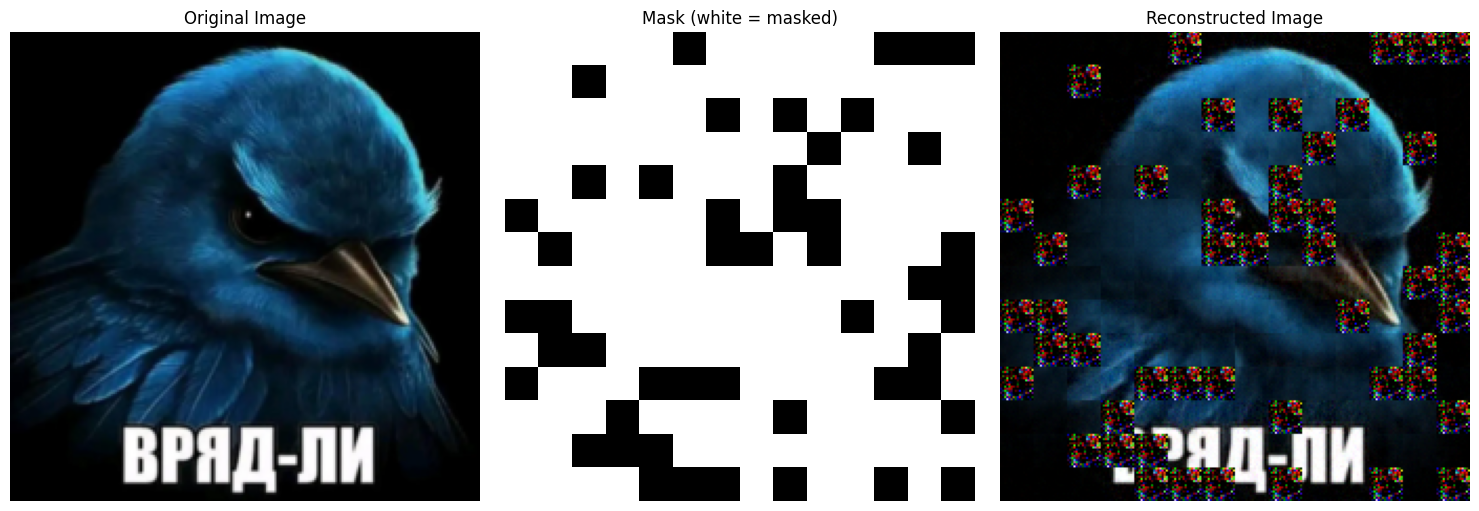

In [16]:
# Визуализация реконструкции
model.eval()
with torch.no_grad():
    # Получаем реконструкцию из модели
    # Вызываем backbone и neck напрямую для получения предсказаний

    latent, mask, ids_restore = model.backbone(imgs)
    pred = model.neck(latent, ids_restore)

    # Преобразуем предсказания обратно в изображение
    # pred имеет форму (B, num_patches, patch_size^2 * channels)
    reconstructed = model.head.unpatchify(pred)

    # Нормализуем для визуализации (приводим к диапазону [0, 1])
    # Если значения уже в [0, 1], просто ограничиваем
    reconstructed = torch.clamp(reconstructed, 0, 1)

# Визуализация с маской
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Оригинальное изображение
orig_img = imgs[0].cpu().permute(1, 2, 0).detach()
axes[0].imshow(orig_img)
axes[0].set_title('Original Image')
axes[0].axis('off')

# Маска (показываем, какие патчи были замаскированы)
# mask имеет форму (B, L), где L - количество патчей
mask_img = mask[0].cpu().detach().numpy()
# Преобразуем 1D маску в 2D изображение
h = w = int(mask_img.shape[0] ** 0.5)
mask_img = mask_img.reshape(h, w)
# # Масштабируем маску до размера изображения для наглядности (опционально, imshow сделает это сам)
axes[1].imshow(mask_img, cmap='gray', interpolation='nearest')
axes[1].set_title('Mask (white = masked)')
axes[1].axis('off')

# Реконструированное изображение
recon_img = reconstructed[0].cpu().permute(1, 2, 0).detach()
axes[2].imshow(recon_img)
axes[2].set_title('Reconstructed Image')
axes[2].axis('off')

plt.tight_layout()
plt.show()

In [17]:
# 1. Отключаем градиенты
for param in model.backbone.parameters():
    param.requires_grad = False

# 2. Переводим бэкбон в режим оценки (замораживает BN-статистики и отключает Dropout)
model.backbone.eval()
model.backbone.mask_ratio = 0

In [18]:

# Настройки обучения
num_epochs = 3000
warmup_epochs = 150


# Создаем оптимизатор
initial_lr = 1e-4


optimizer = torch.optim.AdamW(model.parameters(), lr=initial_lr, weight_decay=0.05, betas=(0.9, 0.999))

# Cosine decay scheduler с warmup
def get_lr(epoch):
    if epoch < warmup_epochs:
        # Linear warmup
        return initial_lr * (epoch + 1) / warmup_epochs
    else:
        # Cosine decay
        progress = (epoch - warmup_epochs) / (num_epochs - warmup_epochs)
        return initial_lr * 0.5 * (1 + math.cos(math.pi * progress))

# Списки для хранения истории обучения
finetune_losses = []

# Training loop
model.train()
for epoch in tqdm(range(num_epochs), desc="Training"):
    # Подготовка данных
    lr = get_lr(epoch)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    data = dict(inputs=imgs, mode='loss')

    # Forward pass
    optimizer.zero_grad()
    outputs = model(**data)
    loss = outputs['loss'].mean()

    # Backward pass
    loss.backward()
    optimizer.step()

    # Сохраняем loss
    finetune_losses.append(loss.item())

    # Логируем каждые 5 эпох
    if (epoch + 1) % 200 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}")

print(f"\nTraining completed!")
print(f"Initial loss: {finetune_losses[0]:.6f}")
print(f"Final loss: {finetune_losses[-1]:.6f}")
print(f"Loss reduction: {((finetune_losses[0] - finetune_losses[-1]) / finetune_losses[0] * 100):.2f}%")

Training:   7%|▋         | 204/3000 [00:09<02:15, 20.70it/s]

Epoch [200/3000], Loss: 0.027118


Training:  13%|█▎        | 402/3000 [00:19<02:05, 20.64it/s]

Epoch [400/3000], Loss: 0.009519


Training:  20%|██        | 603/3000 [00:29<01:56, 20.58it/s]

Epoch [600/3000], Loss: 0.004354


Training:  27%|██▋       | 804/3000 [00:38<01:47, 20.48it/s]

Epoch [800/3000], Loss: 0.002675


Training:  33%|███▎      | 1002/3000 [00:48<01:37, 20.56it/s]

Epoch [1000/3000], Loss: 0.002068


Training:  40%|████      | 1203/3000 [00:58<01:28, 20.31it/s]

Epoch [1200/3000], Loss: 0.001870


Training:  47%|████▋     | 1404/3000 [01:08<01:19, 20.16it/s]

Epoch [1400/3000], Loss: 0.001380


Training:  53%|█████▎    | 1602/3000 [01:18<01:09, 20.14it/s]

Epoch [1600/3000], Loss: 0.001213


Training:  60%|██████    | 1803/3000 [01:28<00:59, 20.24it/s]

Epoch [1800/3000], Loss: 0.001107


Training:  67%|██████▋   | 2004/3000 [01:38<00:49, 20.22it/s]

Epoch [2000/3000], Loss: 0.001035


Training:  73%|███████▎  | 2202/3000 [01:47<00:39, 20.07it/s]

Epoch [2200/3000], Loss: 0.000988


Training:  80%|████████  | 2402/3000 [01:57<00:29, 20.12it/s]

Epoch [2400/3000], Loss: 0.000959


Training:  87%|████████▋ | 2603/3000 [02:07<00:19, 20.15it/s]

Epoch [2600/3000], Loss: 0.000943


Training:  93%|█████████▎| 2803/3000 [02:17<00:09, 20.14it/s]

Epoch [2800/3000], Loss: 0.000936


Training: 100%|██████████| 3000/3000 [02:27<00:00, 20.33it/s]

Epoch [3000/3000], Loss: 0.000935

Training completed!
Initial loss: 0.370333
Final loss: 0.000935
Loss reduction: 99.75%


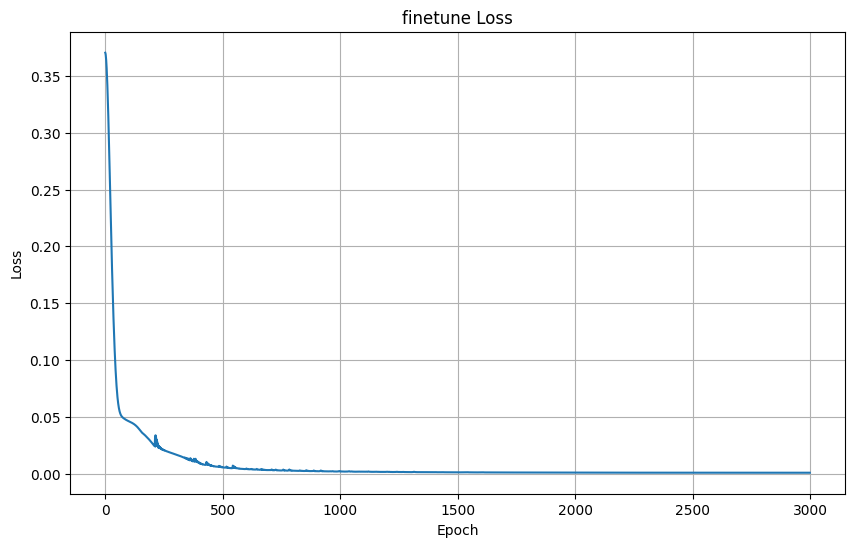

In [19]:
# Визуализация кривой обучения
plt.figure(figsize=(10, 6))
plt.plot(finetune_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('finetune Loss')
plt.grid(True)
plt.show()


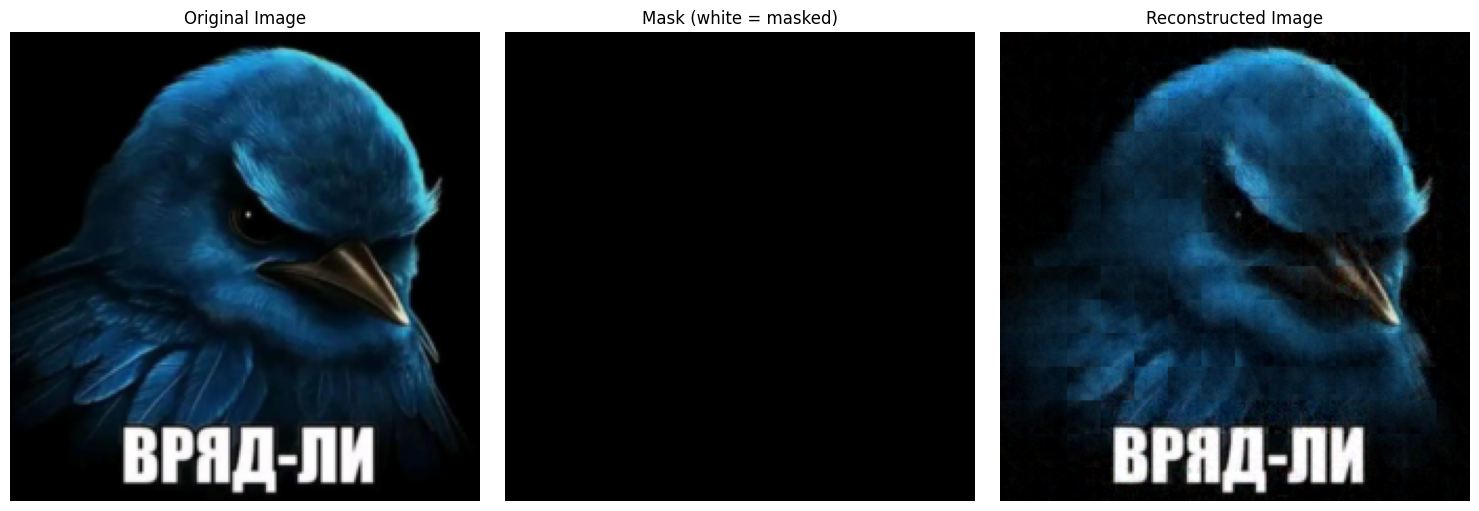

In [20]:
# Визуализация реконструкции
model.eval()
with torch.no_grad():
    # Получаем реконструкцию из модели
    # Вызываем backbone и neck напрямую для получения предсказаний

    latent, mask, ids_restore = model.backbone(imgs)
    pred = model.neck(latent, ids_restore)

    # Преобразуем предсказания обратно в изображение
    # pred имеет форму (B, num_patches, patch_size^2 * channels)
    reconstructed = model.head.unpatchify(pred)

    # Нормализуем для визуализации (приводим к диапазону [0, 1])
    # Если значения уже в [0, 1], просто ограничиваем
    reconstructed = torch.clamp(reconstructed, 0, 1)

# Визуализация с маской
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Оригинальное изображение
orig_img = imgs[0].cpu().permute(1, 2, 0).detach()
axes[0].imshow(orig_img)
axes[0].set_title('Original Image')
axes[0].axis('off')

# Маска (показываем, какие патчи были замаскированы)
# mask имеет форму (B, L), где L - количество патчей
mask_img = mask[0].cpu().detach().numpy()
# Преобразуем 1D маску в 2D изображение
h = w = int(mask_img.shape[0] ** 0.5)
mask_img = mask_img.reshape(h, w)
# # Масштабируем маску до размера изображения для наглядности (опционально, imshow сделает это сам)
axes[1].imshow(mask_img, cmap='gray', interpolation='nearest')
axes[1].set_title('Mask (white = masked)')
axes[1].axis('off')

# Реконструированное изображение
recon_img = reconstructed[0].cpu().permute(1, 2, 0).detach()
axes[2].imshow(recon_img)
axes[2].set_title('Reconstructed Image')
axes[2].axis('off')

plt.tight_layout()
plt.show()

In [19]:
model.neck.decoder_pos_embed

Parameter containing:
tensor([[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  1.0000,  1.0000,  1.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  1.0000,  1.0000,  1.0000],
         ...,
         [ 0.4202, -0.9650,  0.5379,  ...,  1.0000,  1.0000,  1.0000],
         [ 0.4202, -0.9650,  0.5379,  ...,  1.0000,  1.0000,  1.0000],
         [ 0.4202, -0.9650,  0.5379,  ...,  1.0000,  1.0000,  1.0000]]],
       device='cuda:0')

In [20]:
model.backbone.pos_embed

Parameter containing:
tensor([[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  1.0000,  1.0000,  1.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  1.0000,  1.0000,  1.0000],
         ...,
         [ 0.4202, -0.9650,  0.5379,  ...,  1.0000,  1.0000,  1.0000],
         [ 0.4202, -0.9650,  0.5379,  ...,  1.0000,  1.0000,  1.0000],
         [ 0.4202, -0.9650,  0.5379,  ...,  1.0000,  1.0000,  1.0000]]],
       device='cuda:0')

In [16]:
for param in model.backbone.parameters():
    assert not param.requires_grad